In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model

# Load dataset

In [2]:
X1, y1 = np.load(f'datasets/synthetic_0.1_class1/features.npy'), np.load(f'datasets/synthetic_0.1_class1/labels.npy')
X2, y2 = np.load(f'datasets/synthetic_0.2_class1/features.npy'), np.load(f'datasets/synthetic_0.2_class1/labels.npy')
X3, y3 = np.load(f'datasets/synthetic_0.3_class1/features.npy'), np.load(f'datasets/synthetic_0.3_class1/labels.npy')
X4, y4 = np.load(f'datasets/synthetic_0.4_class1/features.npy'), np.load(f'datasets/synthetic_0.4_class1/labels.npy')
X5, y5 = np.load(f'datasets/synthetic_0.5_class1/features.npy'), np.load(f'datasets/synthetic_0.5_class1/labels.npy')

In [3]:
x_dim, samples = X1.shape

In [4]:
X = np.zeros((5,x_dim,samples)); y = np.zeros((5,samples))

X[0], X[1], X[2], X[3], X[4] = X1, X2, X3, X4, X5
y[0], y[1], y[2], y[3], y[4] = y1, y2, y3, y4, y5

# Optimal solution

In [5]:
# calculate class means 

mu0 = 0
mu1 = 0
samples_1 = np.sum(y[4])
samples_0 = samples - samples_1

for t in range(samples):
    if y[4,t] == 0:
        mu0 += X[4,:,t]
    elif y[4,t] == 1:
        mu1 += X[4,:,t]

mu0 /= samples_0
mu1 /= samples_1

# calculate sample variance

cov = 0

for t in range(samples):
    if y[4,t] == 0:
        cov += np.outer(X[4,:,t]-mu0,X[4,:,t]-mu0)

cov /= samples_0

In [6]:
w_opt = np.linalg.inv(cov)@(mu0-mu1)
w_opt_norm = np.linalg.norm(w_opt)
bias_opt = .5*np.inner(w_opt,mu0+mu1)

# Bio-LDA

In [7]:
trials = 10; epochs = 1; iters = epochs*samples; eta0 = 1e-1; decay = 1e-3

In [8]:
classes = np.unique(y[0])

In [9]:
model = sklearn.linear_model.SGDClassifier(
    fit_intercept=False,
    learning_rate="constant",
    eta0=1E-3,  # this is the learning rate
    )

In [10]:
accuracy = np.zeros((5,trials,iters))
accuracy_svm = np.zeros((5,trials,iters))

for p in range(5):

    print(f'p = {(p+1)/10}')

    for trial in range(trials):

        print(f'Trial {trial+1}:')

        w = np.random.randn(x_dim); sample_mu0 = 0; zeta = 0; sample_bias = 0; l = 1

        for epoch in range(epochs):

            idx = np.random.permutation(samples)

            for t in range(samples):

                iter = epoch*samples + t

                x, class_label = X[p,:,idx[t]], y[p,idx[t]]

                c = np.inner(w,x)

                step = eta0/(1+decay*iter)

                if class_label==0:

                    sample_mu0 += (x-sample_mu0)/1000
                    sample_bias += (c/2-sample_bias)/1000
                    zeta += (c-zeta)/1000

                    w += step*(sample_mu0-(c-zeta)*(x-sample_mu0))

                    l += 1

                elif class_label==1:

                    sample_bias += (l*c/2-np.log(l)-sample_bias)/1000
                    w += step*(-l*x)
                    l = 1

                z = c-sample_bias

                accuracy[p,trial,iter] = np.abs((np.sign(z)+1)/2 - class_label)

                # svm update

                model.partial_fit(x.reshape(1,x_dim), np.array([class_label,]), classes)
                accuracy_svm[p,trial,iter] = 1 - np.abs(model.predict(x.reshape(1,x_dim))-class_label)

p = 0.1
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:
p = 0.2
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:
p = 0.3
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:
p = 0.4
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:
p = 0.5
Trial 1:
Trial 2:
Trial 3:
Trial 4:
Trial 5:
Trial 6:
Trial 7:
Trial 8:
Trial 9:
Trial 10:


In [11]:
mean_accuracy = np.zeros((5,trials,iters))
mean_accuracy_svm = np.zeros((5,trials,iters))

for p in range(5):

    for trial in range(trials):

        for iter in range(iters):

            if iter<100:
                mean_accuracy[p,trial,iter] = np.sum(accuracy[p,trial,0:iter])/max(iter,1)
                mean_accuracy_svm[p,trial,iter] = np.sum(accuracy_svm[p,trial,0:iter])/max(iter,1)
            
            elif iter>=100:
                mean_accuracy[p,trial,iter] = np.sum(accuracy[p,trial,iter-100:iter])/100
                mean_accuracy_svm[p,trial,iter] = np.sum(accuracy_svm[p,trial,iter-100:iter])/100

In [12]:
np.save('synthetic.npy',mean_accuracy)
np.save('synthetic_svm.npy',mean_accuracy_svm)

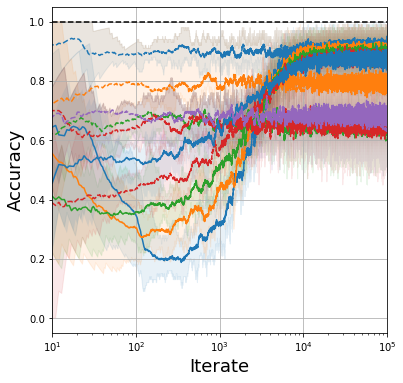

In [20]:
fs = 18

t = np.linspace(1,iters,iters)

fig = plt.figure(figsize=(6,6))

plt.semilogx(t,mean_accuracy[0].mean(axis=0),color='C0')
plt.fill_between(t,np.amin(mean_accuracy[0],axis=0),np.amax(mean_accuracy[0],axis=0),alpha=.1,color='C0')
plt.semilogx(t,mean_accuracy_svm[0].mean(axis=0),color='C0',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[0],axis=0),np.amax(mean_accuracy_svm[0],axis=0),alpha=.1,color='C0')
plt.semilogx(t,mean_accuracy[1].mean(axis=0),color='C1')
plt.fill_between(t,np.amin(mean_accuracy[1],axis=0),np.amax(mean_accuracy[1],axis=0),alpha=.1,color='C1')
plt.semilogx(t,mean_accuracy_svm[1].mean(axis=0),color='C1',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[1],axis=0),np.amax(mean_accuracy_svm[0],axis=0),alpha=.1,color='C1')
plt.semilogx(t,mean_accuracy[2].mean(axis=0),color='C2')
plt.fill_between(t,np.amin(mean_accuracy[2],axis=0),np.amax(mean_accuracy[2],axis=0),alpha=.1,color='C2')
plt.semilogx(t,mean_accuracy_svm[2].mean(axis=0),color='C2',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[2],axis=0),np.amax(mean_accuracy_svm[2],axis=0),alpha=.1,color='C2')
plt.semilogx(t,mean_accuracy[3].mean(axis=0),color='C3',ls='--')
plt.fill_between(t,np.amin(mean_accuracy[3],axis=0),np.amax(mean_accuracy[3],axis=0),alpha=.1,color='C3')
plt.semilogx(t,mean_accuracy_svm[3].mean(axis=0),color='C3',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[3],axis=0),np.amax(mean_accuracy_svm[2],axis=0),alpha=.1,color='C3')
plt.semilogx(t,mean_accuracy[4].mean(axis=0))
plt.fill_between(t,np.amin(mean_accuracy[4],axis=0),np.amax(mean_accuracy[4],axis=0),alpha=.1)
plt.semilogx(t,mean_accuracy_svm[4].mean(axis=0),color='C4',ls='--')
plt.fill_between(t,np.amin(mean_accuracy_svm[4],axis=0),np.amax(mean_accuracy_svm[2],axis=0),alpha=.1,color='C4')
plt.axhline(y=1,c='black',ls='--')
plt.xlim(1e1,iters)
plt.xlabel('Iterate',fontsize=fs)
plt.ylabel('Accuracy',fontsize=fs)
plt.grid()

plt.show()